## グローバーのアルゴリズム

qiskitを利用して、量子アルゴリズムについて自分なりに勉強していこうと思います。
個人的な勉強の記録なので、説明などを大幅に省いている可能性があります。

qiskitのウェブサイト通りに勉強を進めています。

- https://qiskit.org/textbook/ja/ch-algorithms/quantum-phase-estimation.html

グローバーのアルゴリズムは探索問題を非常に高速に行える事で有名です。
通常のリスト構造を持つ配列の探索問題の場合、逐次探索を実行することで、最良の場合で$O(1)$、最悪の場合で$O(N)$の計算時間を必要とします。
また、リストがソート済みの場合、二部探索を利用する事で$O(N)$となり、指数関数的に高速になります。

グローバーのアルゴリズムはデータが非構造化であっても、ソートされていなくも$O(\sqrt{N})$の計算速度を実現することが出来ます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/qiskit/grover/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/qiskit/grover/base_nb.ipynb)

### 筆者の環境

In [53]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G103


In [54]:
!python -V

Python 3.8.5


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import qiskit
import json

import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

from qiskit import execute
from qiskit_textbook.tools import array_to_latex

from qiskit.visualization import plot_histogram

dict(qiskit.__qiskit_version__)

{'qiskit-terra': '0.17.4',
 'qiskit-aer': '0.8.2',
 'qiskit-ignis': '0.6.0',
 'qiskit-ibmq-provider': '0.13.1',
 'qiskit-aqua': '0.9.1',
 'qiskit': '0.26.2',
 'qiskit-nature': None,
 'qiskit-finance': None,
 'qiskit-optimization': None,
 'qiskit-machine-learning': None}

## 理論部分の理解

### 振幅増幅

単純に考えると、$n$ビットを用意して、$2^n$個の状態と探索したい値をマッピングさせ、測定したい状態の一つを探索する事が思いつきます。
ただ、初期状態だと、すべての状態の振幅が同じであるため、重ね合わせの状態から一つの状態を探索するには、平均$2^n$回の測定が必要になります。

それを解決するのが振幅増幅という考え方です。探索したい状態の振幅をユニタリ演算子を適用することで増幅させ、測定したい状態が非常に高い確率で測定される状態を作り出す事です。

ここですべての状態を、ターゲットの状態$(|\omega\rangle)$とそれに直交する状態$(|s'\rangle)$の二つに分解し、その二つが作るベクトル空間を考えます。
すべての重ね合わせの状態が均等に分布している$|s\rangle$は、ある位相$\theta$を利用して、

$$
|s\rangle = \cos \theta\left|s^{\prime}\right\rangle + \sin \theta|w\rangle
$$

と表現できます。以下、この状態から回転の操作を施し、ターゲットベクトルの振幅増幅を行います。

### 回転操作のイメージ図

振幅増幅のアルゴリズムは、以下の$U_f$と$U_s$という操作を行うことで、初期状態では$|s'\angle$の振幅が大きかった状態から$|\omega\rangle$の振幅を最大にする事です。

![svg](base_nb_files_local/grover.svg)

### U_f(反転Us)

$|\omega\rangle$の成分の振幅を反転させます。

$$
U_{f}=\left(\begin{array}{ll}
1 & 0 \\
0 & -1
\end{array}\right)
$$

### U_s(sに対する反転)

$|s\rangle$に対して反転させます。対称に反転させるには三つの行程を経る必要があります。

#### 1. -theta だけ回転
$$
U_{s_1}=\left(\begin{array}{cc}
\cos (-\theta) & -\sin (-\theta) \\
\sin (-\theta) & \cos (-\theta)
\end{array}\right)
$$

#### 2. s'軸の振幅を反転
$$
U_{s_{2}}=\left(\begin{array}{ll}
1 & 0 \\
0 & -1
\end{array}\right)
$$

#### 3. thetaだけ回転
$$
U_{s_3}=\left(\begin{array}{cc}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right)
$$

### 組み合わせ

上記の1-3を組み合わせ、$|s\rangle$に対する対称の反転を表すことが出来きます。

$$
\begin{aligned}
U_s=U_{s_3} U_{s_2} U_{s_1} &=\left(\begin{array}{cc}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right)\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)\left(\begin{array}{cc}
\cos \theta & \sin \theta \\
-\sin \theta & \cos \theta
\end{array}\right) \\
&=\left(\begin{array}{cc}
\cos 2 \theta & 2 \sin \theta \cos \theta \\
2 \sin \theta \cos \theta & -\cos 2 \theta
\end{array}\right) \\
&=\left(\begin{array}{cc}
\cos 2 \theta & \sin 2 \theta \\
\sin 2 \theta & -\cos 2 \theta
\end{array}\right)
\end{aligned}
$$

### U_sとU_fの組み合わせ

$$
\begin{aligned}
U_{s} U_{f} &=\left(\begin{array}{cc}
\cos 2 \theta & \sin 2 \theta \\
\sin 2 \theta & -\cos 2 \theta
\end{array}\right)\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right) \\
&=\left(\begin{array}{cc}
\cos 2 \theta & -\sin 2 \theta \\
\sin 2 \theta & \cos 2 \theta
\end{array}\right)
\end{aligned}
$$

この行列は、

$$
|s\rangle = \cos \theta\left|s^{\prime}\right\rangle + \sin \theta|w\rangle
$$

をさらに$2\theta$だけ回転させる行列なので、

$$
\begin{aligned}
&U_s U_{f}\left(\cos \theta\left|s^{\prime}\right\rangle+\sin \theta|\omega\rangle\right) \\
&=\cos 3 \theta\left|s^{\prime}\right\rangle+\sin 3 \theta|w\rangle
\end{aligned}
$$

となり、結果的に$3\theta$の位相を持つ事になります。

一般化して$k$回操作を行うと、

$$
\begin{aligned}
&\left(U_{s} V_{f}\right)^{k}\left(\cos \theta\left|s^{\prime}\right\rangle+\sin \theta|\omega\rangle\right)\\
&=\cos (2 k+1) \theta\left|s^{\prime}\right\rangle+\sin (2 k+1) \theta|\omega\rangle
\end{aligned}
$$

通常の探索問題では、$\theta$は非常に小さい（探索対象となる項目は探索するすべての項目と比較してとても小さい）ですが、何度もこの操作を繰り返すと$2k+1$倍されて、$|\omega\rangle$の振幅が大きくなっていきます。

### 測定回数の目安

ここで、$\displaystyle (2k + 1)\theta \approx \frac{\pi}{2}$の時に、$|\omega\rangle$が検出される確率が最大になるので、

$$
k = \frac{\pi}{4\theta} - \frac{1}{2}
$$

が目安となる回転の操作の回数となる。ここで、$\theta$が非常に小さいという仮定があるので、探索対象となる項目数が$M$で、全項目数が$N$とすると、

$$
\theta \sim \sin\theta = \sqrt{\frac{M}{N}}
$$

となるので、

$$
k \sim O\left(\sqrt{\frac{N}{M}}\right)
$$

という測定回数で、対称のデータに対して確率振幅を最大化する事ができる事が分かります。

## qiskitで実装

2量子ビットの場合に$U_f$や$U_s$がどのような回路になるか、実際に試してみたいと思います。
探索ターゲットは$|11\angle$とします。

### U_f

$U_f$については、ターゲットビットだけを反転させれば良いので、CZゲートが適用できます。

In [45]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cz(0,1)

backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\\\\\text{Statevector} = ")

<IPython.core.display.Math object>

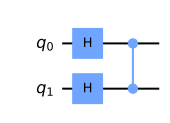

In [46]:
qc.draw('mpl')

### U_s

$U_s$は、アダマールゲート => CZゲート => アダマールゲートの順番で適用すれば実現できます。

$$
U_{s} = H^{\otimes n} U_{0} H^{\otimes n}
$$

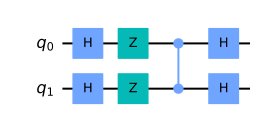

In [48]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.z(0)
qc.z(1)
qc.cz(0,1)
qc.h(0)
qc.h(1)

qc.draw('mpl')

### 測定
$U_s$と$U_f$を２量子ビットに適用し、グローバーのアルゴリズムが成り立つことを確認してみます。

In [49]:

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cz(0,1)

qc.h(0)
qc.h(1)
qc.z(0)
qc.z(1)
qc.cz(0,1)
qc.h(0)
qc.h(1)

backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\\\\\\\text{Statevector} = ")

<IPython.core.display.Math object>

となり、ターゲットであった$|11\rangle$の測定確率が最大となりました。